In [32]:
import logging
from pathlib import Path
import json
import copy

# Load the relevant libraries (all available from anaconda)
import geojson
import networkx as nx
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, LineString
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
import pyproj
import shapely
import requests

# This a small library that is included. These might move to a seperate repo.
from dtv_backend.network.pyFIS import pyFIS
import dtv_backend.network.build_network_functions as bnf



# %matplotlib inline

In [2]:
# Enable logging messages
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [3]:
# store results in this folder
outputdir = Path('result')
assert outputdir.exists()

# Get data from FIS
In this section we extract data from vaarweginformatie.nl using the pyFIS library. 

### FIS calls and processing

In [4]:
# Connect to FIS
FIS = pyFIS()

In [5]:
# Get all section (=vaarwegvakken) and properties from FIS
section = FIS.list_objects('section')   # TODO: Do not keep all columns
maximumdimensions = FIS.list_objects('maximumdimensions')
navigability = FIS.list_objects('navigability') 

Removing 4 nan-geometries from dataset


In [6]:
maximumdimensions_columns = [
    'Id', 'GeneralDepth', 'GeneralLength', 'GeneralWidth', 'Note',
    'SeaFairingDepth', 'PushedLength',
    'PushedWidth', 'GeneralHeight', 'SeaFairingLength', 'SeaFairingWidth',
    'CoupledLength', 'CoupledWidth', 'PushedDepth', 'WidePushedDepth',
    'CoupledDepth', 'WidePushedLength', 'WidePushedWidth',
    'SeaFairingHeight'
]

navigability_columns = ['Id', 'Classification', 'Code', 'Description']

# Merge data of all three datasets

## This did not work out
## section = section.merge(maximumdimensions[maximumdimensions_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_maximumdimensions'))
## section = section.merge(navigability[navigability_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_navigability'))

# This is very slow.
section['maximumdimensions_id'] = FIS.get_object_subobjects_list('section', section.Id.values, 'maximumdimensions')
section['navigability_id'] = FIS.get_object_subobjects_list('section', section.Id.values, 'navigability')

section = section.merge(maximumdimensions[maximumdimensions_columns], left_on='maximumdimensions_id', right_on='Id', how='left', suffixes=('', '_maximumdimensions'))
section = section.merge(navigability[navigability_columns], left_on='navigability_id', right_on='Id', how='left', suffixes=('', '_navigability'))


# Add property length
# section['length'] = section.length.values

# Remove sections that do not have an ID as start or end point (in the selection polygon this is only the end of the Linge)
# Alternative: Make up new node names for these locations and also add those locations to the section_node table
section = section[~section[['StartJunctionId', 'EndJunctionId']].isna().any(axis=1)]

section = section.set_index('Id')
section_drop_columns = [
    'GeoGeneration', 'VinCode', 'Direction', 'RouteKmEnd', 
    'RouteKmBegin', 'TypeId', 'FairwayId', 
    'RouteId', 'ForeignCode', 'maximumdimensions_id', 
    'navigability_id', 'Id_maximumdimensions', 'Note'
]
section = section.drop(section_drop_columns, axis=1, errors='ignore')

section.to_file(outputdir / 'FIS_section.geojson', driver='GeoJSON')

100%|██████████| 4394/4394 [12:58<00:00,  5.64it/s]


In [7]:
# Get nodes from FIS --> Not using these, some strange inconsistencies with the sections...
# section_node = FIS.list_objects('sectionjunction').set_index('Id')

node_start_columnname="StartJunctionId"
node_end_columnname="EndJunctionId"

all_active_section_nodes = pd.Series(section[node_start_columnname].to_list() + section[node_end_columnname].to_list()).unique()
section_node = bnf.create_nodes_from_geodataframe(all_active_section_nodes, section)

section_node.to_file(outputdir / 'FIS_section_node_manual.geojson', driver='GeoJSON')

In [8]:
# Get all bridges including openings
bridges = FIS.merge_geotypes('bridge', 'opening')

bridge_columns = ['Id', 'Name', 'NumberOfOpenings', 'HeightClosed', 'CanOpen', 'geometry']
bridges = bridges[bridge_columns]

bridges_grouped = bnf.group_subobjects(bridges, fieldname='HeightClosed')

bridges.to_file(outputdir / 'FIS_bridges.geojson', driver='GeoJSON')
bridges_grouped.to_file(outputdir / 'FIS_bridges_grouped.geojson', driver='GeoJSON')

In [9]:
# Get all locks including chambers
locks = FIS.merge_geotypes('lock', 'chamber')

locks_columns = ['Id', 'Name', 'geometry', 'NumberOfChambers', 'Length_chamber', 'Width_chamber']
locks = locks[locks_columns]

locks_grouped = bnf.group_subobjects(locks, fieldname='Id')

locks.to_file(outputdir / 'FIS_locks.geojson', driver='GeoJSON')
locks_grouped.to_file(outputdir / 'FIS_locks_grouped.geojson', driver='GeoJSON')

In [10]:
# Get all structures and their openings
structures = FIS.merge_geotypes('exceptionalnavigationalstructure', 'opening').set_index('Id')

# Rename type to readable names
structures['StructureType'] = structures['StructureType'].replace({
    'ADT': 'Aquaduct',
    'GDK': 'Grondduiker',
    'KBK': 'Noodkering',
    'KBL': 'Kabel',
    'KSS': 'Keersluis',
    'ONB': 'Onbekend??',
    'PIL': 'Pijpleiding',
    'STW': 'Stuw',
    'SVK': 'Stormvloedkering',
    'TNL': 'Tunnel',
    'TSB': 'Transportleiding',
    'VKW': 'Voormalig kunstwerk'
})

# Select only the blocking structures
structures = structures[structures['StructureType'].isin(['Keersluis', 'Stuw', 'Stormvloedkering'])]

# Only keep these columns for now
structures_columns = ['Name', 'geometry', 'StructureType']
structures = structures[structures_columns]

structures.to_file(outputdir / 'FIS_structures.geojson', driver='GeoJSON')

In [11]:
# Get all berths from FIS
berth = FIS.list_objects('berth').set_index('Id')

# Get only berths marked as 'Overnachtingshaven' (not loading/unloading)
berth = berth.loc[[('OVERNIGHT_ACCOMODATION' in c) for c in berth['Category']]]

# Convert polygons to points
berth['geometry'] = berth.geometry.centroid

berth_grouped = berth.dissolve(by=['RouteId', 'RouteKmBegin'], aggfunc={
    'GeoType': len, 
    'Length': np.max,
    'Width': np.max,
    'MaximalShipLength': np.max,
    'Name': 'first'
})

# Only keep these columns
berth_columns = ['Name', 'geometry', 'Length', 'Width', 'MaximalShipLength']
berth = berth[berth_columns]

berth_grouped = berth_grouped.rename({'GeoGeneration': 'NumberOfBerths'}, axis=1)
berth_grouped.index = [f'Berth{ii}' for ii in range(berth_grouped.shape[0])]
berth_grouped.geometry = berth_grouped.centroid

berth.to_file(outputdir / 'FIS_berth.geojson', driver='GeoJSON')
berth_grouped.to_file(outputdir / 'FIS_berth_grouped.geojson', driver='GeoJSON')

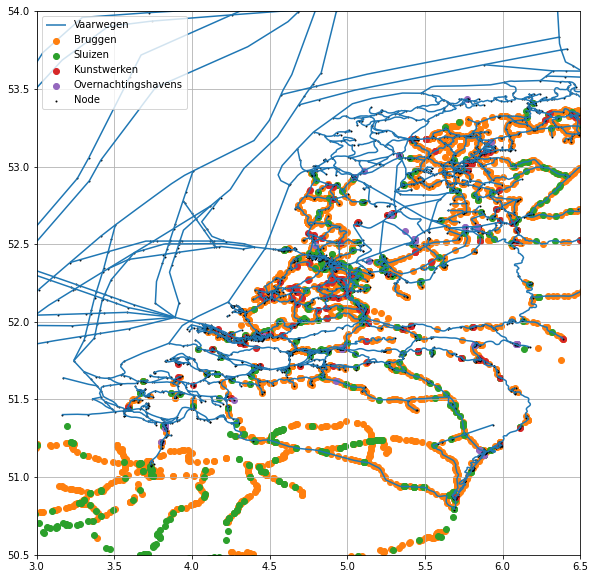

In [12]:
# Create plot to see what data we've loaded
f, ax  = plt.subplots(figsize=(14,10))
section.plot(color='C0', ax=ax, label='Vaarwegen')
bridges.plot(c='C1', ax=ax, label='Bruggen')
locks.plot(c='C2', ax=ax, label='Sluizen')
structures.plot(c='C3', ax=ax, label='Kunstwerken')
berth.plot(c='C4', ax=ax, label='Overnachtingshavens')
section_node.plot(color='k', ax=ax, markersize=1, label='Node')
ax.grid()
plt.legend(loc='upper left')

# Zoom to NL
plt.xlim(3, 6.5)
plt.ylim(50.5, 54);

plt.savefig(outputdir / 'FIS_NL.png', dpi=150, bbox_inches='tight')
plt.show()

### Expand with foreign Network

In [13]:
# Load Fairway for foreign network
fairway = FIS.list_objects('fairway').set_index('Id')
fairway.index = [f'F{f}' for f in fairway.index]             

# Remove Dutch network (nans)
fairway = fairway.loc[~fairway['ForeignCode'].isna()]

# Remove where FairwayNumber isna. This deletes some crappy data...
# fairway = fairway.loc[~fairway['FairwayNumber'].isna()]


# Add columns from other fairway objects
# --> Disabled, no additional data available for foreign network
# fairwayclassification = FIS.list_objects('fairwayclassification')
# fairwaydepth = FIS.list_objects('fairwaydepth') 
# fairwaystatus = FIS.list_objects('fairwaystatus') 

# fairwayclassification_columns = ['geometry', 'Type', 'TypeDescription']
# fairwaydepth_columns = ['geometry', 'MinimalDepthLowerLimit', 'MinimalDepthUpperLimit', 'ReferenceLevel']
# fairwaystatus_columns = ['geometry', 'TrajectCode', 'StatusCode', 'StatusDescription']


# fairway = fairway.merge(fairwayclassification[fairwayclassification_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_fairwayclassification'))
# fairway = fairway.merge(fairwaydepth[fairwaydepth_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_fairwaydepth'))
# fairway = fairway.merge(fairwaystatus[fairwaystatus_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_fairwaystatus'))

# Add Length column and filter very small branches
fairway['length_deg'] = fairway.geometry.length
max_distance = 0.005
fairway = fairway.loc[fairway['length_deg'] > max_distance]

fairway_drop_columns = ['Direction', 'FairwayNumber', 'VinCode',  'RouteId', 'RouteKmBegin', 'RouteKmEnd', 'GeoGeneration', 'ForeignCode',]
fairway = fairway.drop(fairway_drop_columns, axis=1)

In [14]:
# The following code will process the fairway files to find all intersection, construction 
# a network from it with ID's to all start and end point

fairway = bnf.find_crossings_in_branches(fairway)

fairway['length_deg'] = fairway.geometry.length  # Update length for new branches
fairway.to_file(outputdir / 'FIS_fairway.geojson', driver='GeoJSON')

In [15]:
# Extract start/end-nodes from fairways
all_nodes = np.unique(fairway[node_start_columnname].to_list() + fairway[node_end_columnname].to_list())
fairway_nodes = bnf.create_nodes_from_geodataframe(all_nodes, fairway)
fairway_nodes.to_file(outputdir / 'FIS_fairway_nodes.geojson', driver='GeoJSON')

### Merge inland and foreign network

In [16]:
# This code will link the network of section and fairway together by renaming nodes in fairway
rename = {}
for n, point in fairway_nodes.items():
    nearby_points = bnf.all_points_in_radius(point, section_node.geometry.values, radius=max_distance)
    if len(nearby_points) > 0:
        logger.debug(f'Found a match{n}, section_node.iloc[nearby_points].index')
        rename[n] = section_node.index[nearby_points[0]]  # Rename to first point
        
fairway[[node_start_columnname, node_end_columnname]] = fairway[[node_start_columnname, node_end_columnname]].replace(rename)

In [17]:
# Merge fairway and section

section_fairway = pd.concat([section, fairway], axis=0, sort=False)
section_fairway_node = pd.concat([section_node, fairway_nodes], axis=0, sort=False)

section_fairway.reset_index().to_file(outputdir / 'FIS_section_fairway.geojson', driver='GeoJSON')
section_fairway_node.to_file(outputdir / 'FIS_section_fairway_node.geojson', driver='GeoJSON')

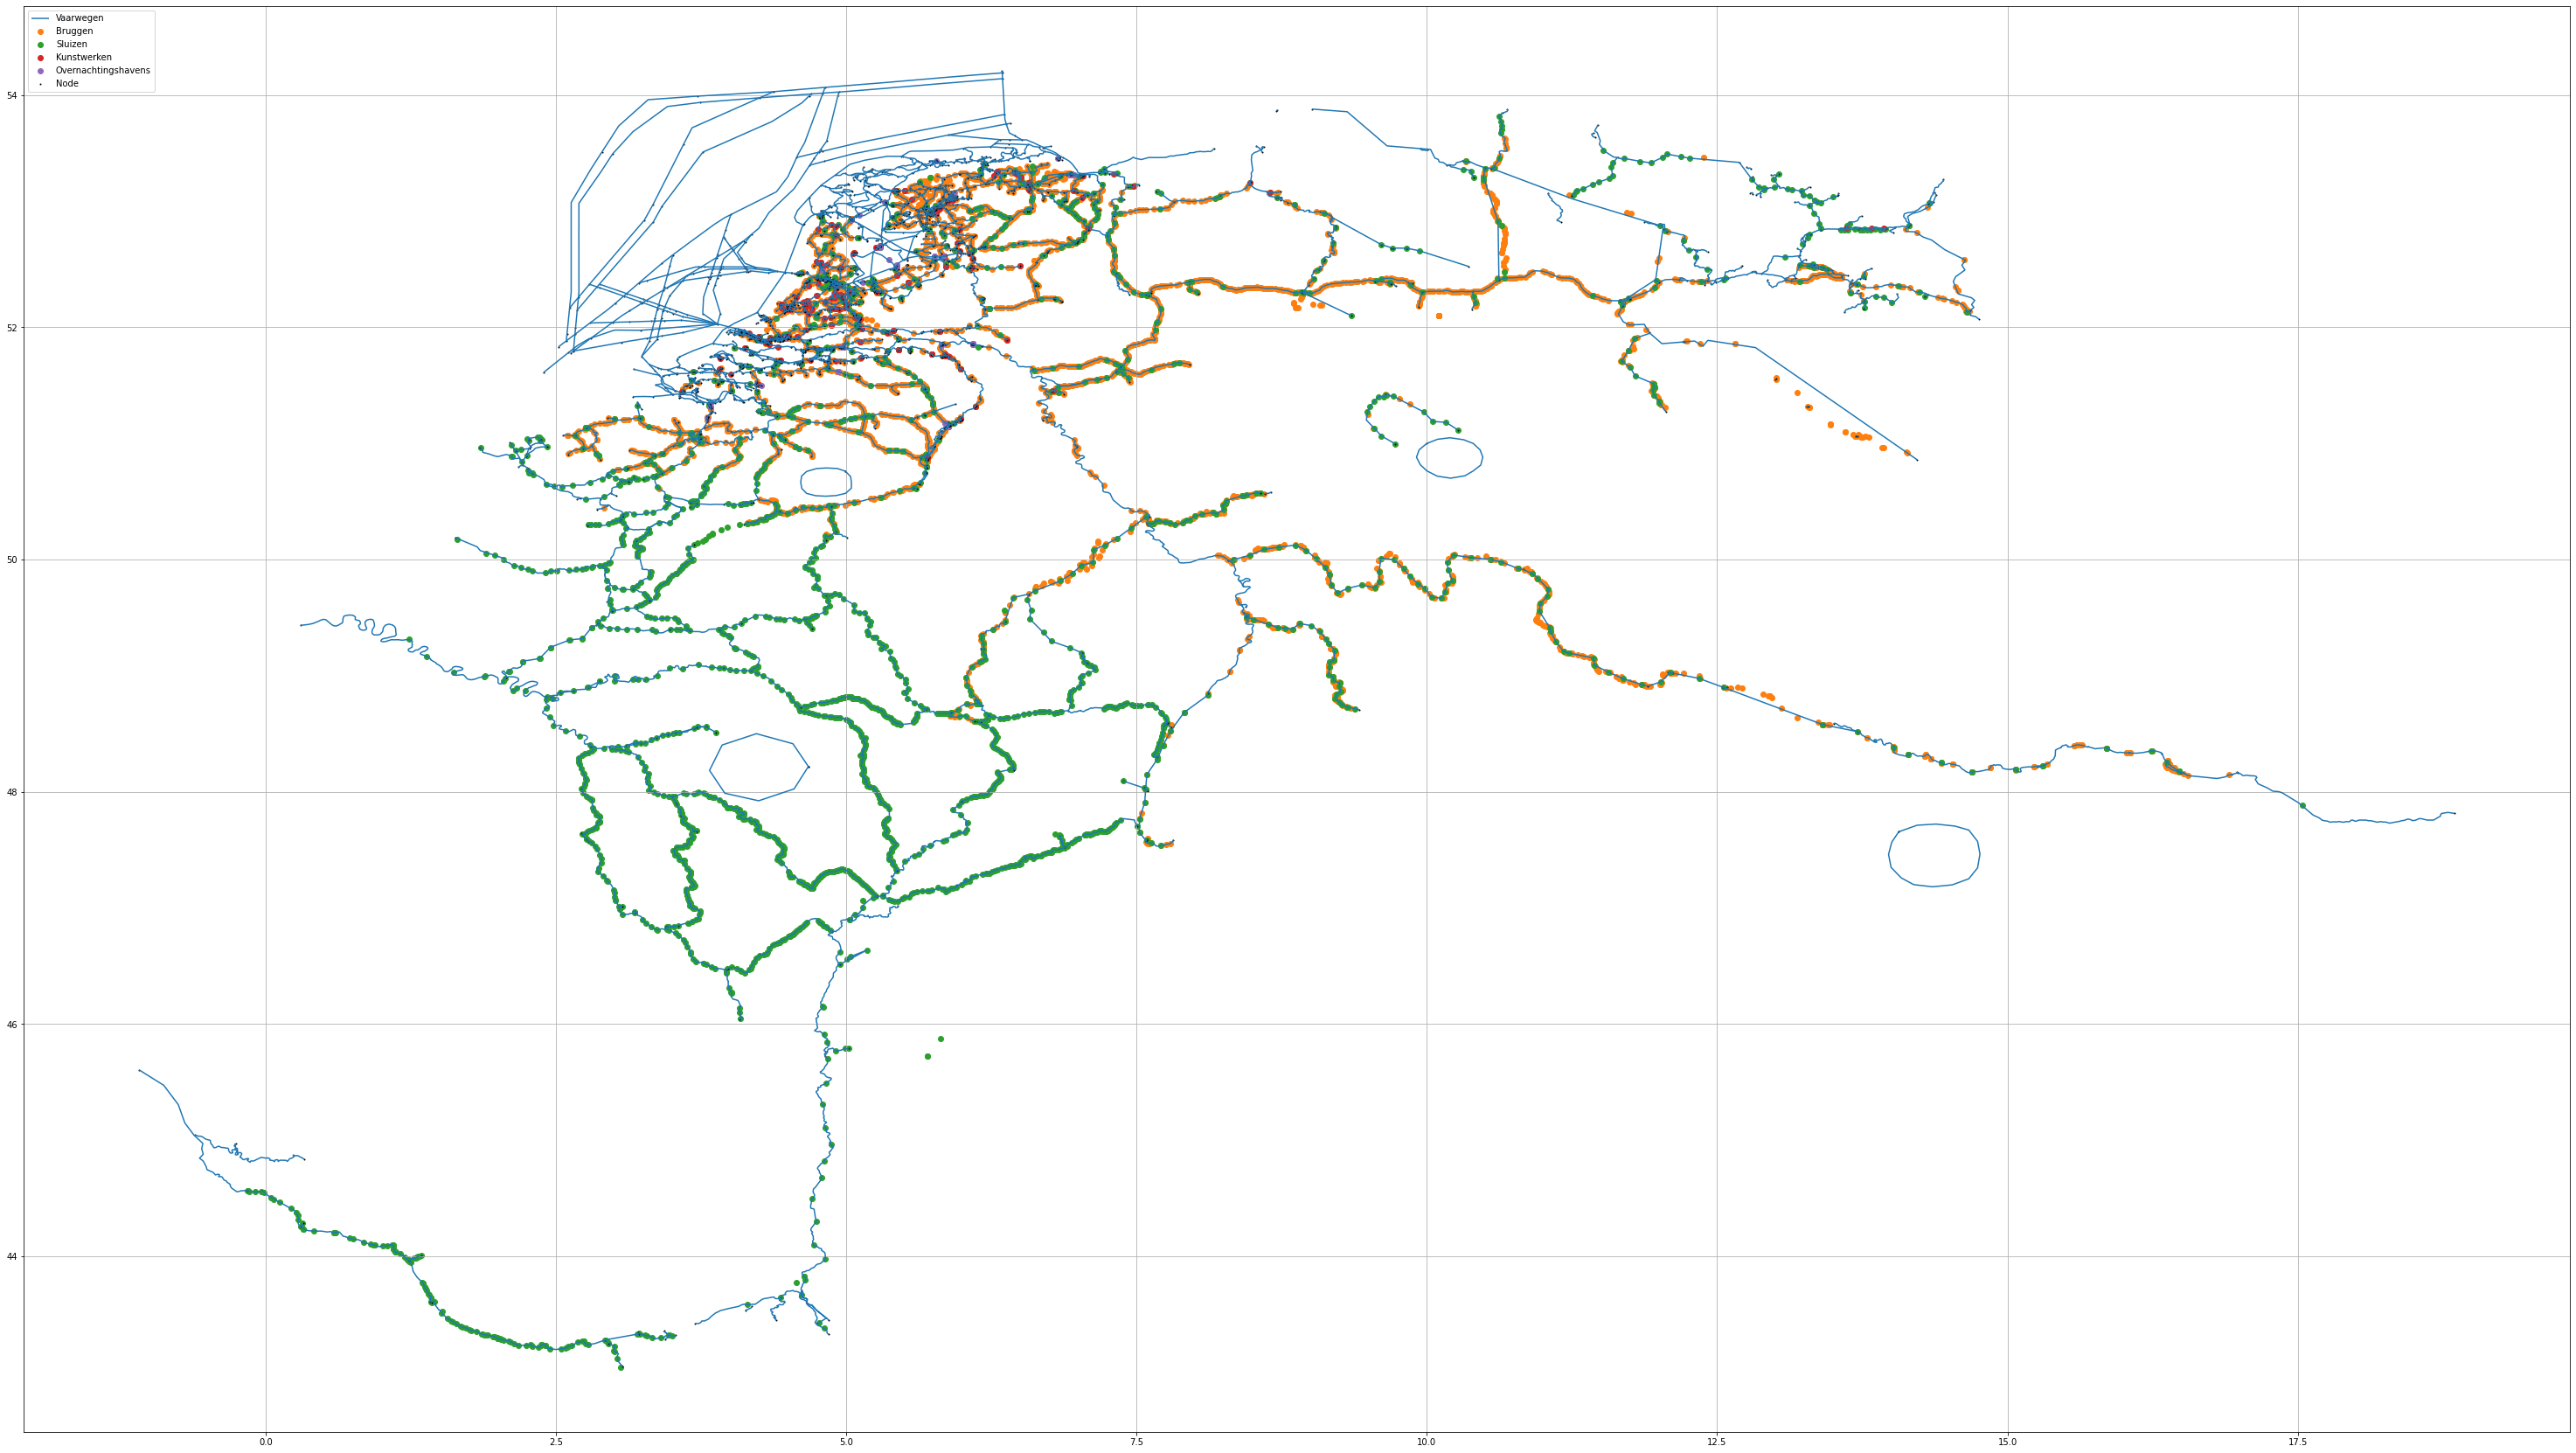

In [18]:
# Create plot to see what data we've loaded
f, ax  = plt.subplots(figsize=(70,30))
section_fairway.plot(color='C0', ax=ax, label='Vaarwegen')
bridges.plot(c='C1', ax=ax, label='Bruggen')
locks.plot(c='C2', ax=ax, label='Sluizen')
structures.plot(c='C3', ax=ax, label='Kunstwerken')
berth.plot(c='C4', ax=ax, label='Overnachtingshavens')
section_fairway_node.plot(color='k', ax=ax, markersize=1, label='Node')
ax.grid()
plt.legend(loc='upper left')

# plt.xlim(3, 8)
# plt.ylim(47, 54);
# plt.savefig()

plt.savefig(outputdir / 'FIS_Totaal.png', dpi=150, bbox_inches='tight')
plt.show()

# Split network at branches
There can be several locations on branches. We split the network at these locations so that you can include logic to pass a lock, pass below a bridge. In the discrete event simulation or navigation this helps to optimize computations. 

In [19]:
# Split branches at all bridges, locks and structures and create a new branch with a specific length
section_fairway = bnf.split_lines_around_points(section_fairway, bridges_grouped, max_distance=0.002, prefix='B', geotype='bridge', dx=0.0001)
section_fairway = bnf.split_lines_around_points(section_fairway, locks_grouped, max_distance=0.002, prefix='L', geotype='lock', dx=0.0004)
section_fairway = bnf.split_lines_around_points(section_fairway, structures, max_distance=0.002, prefix='S', geotype='structure', dx=0.0001)

In [20]:
# Split branches at all berth, creating a new node
section_fairway = bnf.split_lines_at_points(section_fairway, berth_grouped, max_distance=0.002, prefix='')

In [21]:
# Create nodes from coordinates of branches
all_nodes = pd.Series(section_fairway[node_start_columnname].to_list() + section_fairway[node_end_columnname].to_list()).unique()
section_fairway_node = bnf.create_nodes_from_geodataframe(all_nodes, section_fairway)

In [22]:
# Export final data to geojson
section_fairway.reset_index().to_file(outputdir / 'network_section_fairway.geojson', driver='GeoJSON')
section_fairway_node.to_file(outputdir / 'network_section_fairway_node.geojson', driver='GeoJSON')

# Build network
Based on the geometry we can now define a more abstract graph. A graph representation is similar to a subway map. It does not store the exact locations but it does store the topological relations between all the locations. 

In [23]:
def build_network(section_selection_with_bridges_with_locks):
    section_selection_with_bridges_with_locks['length'] = section_selection_with_bridges_with_locks.length.values
    section_selection_with_bridges_with_locks['Wkt'] = [a.wkt for a in section_selection_with_bridges_with_locks.geometry]
    section_selection_with_bridges_with_locks = section_selection_with_bridges_with_locks.drop('geometry', axis=1)
    
    network = nx.from_pandas_edgelist(section_selection_with_bridges_with_locks, 'StartJunctionId', 'EndJunctionId', edge_attr=True)
    
    return network

network_includingHanging = build_network(section_fairway)

In [24]:
# Only keep the largest component (subgraph) and remove all disconnected subgraphs.
largest_component = max(nx.connected_components(network_includingHanging), key=len)
network = network_includingHanging.subgraph(largest_component).copy()

In [25]:
# Add node properties
for n in network.nodes:
    network.nodes[n]['X'] = section_fairway_node.loc[n].x
    network.nodes[n]['Y'] = section_fairway_node.loc[n].y
    network.nodes[n]['geometry'] = '{}'.format(Point(section_fairway_node.loc[n].x, section_fairway_node.loc[n].y))

In [26]:
# The network version 0.1 contains the lat/lon distance in a length property.
# But we need the "great circle" or projected distance.
# Let's define a function to recompute it.

def add_geometries(network):
    network = copy.deepcopy(network)
    geod = pyproj.Geod(ellps="WGS84")



    def edge_length(geom):
        """compute the great circle length of an edge"""
        # get lon, lat
        lats, lons = np.array(geom).T
        distance = geod.line_length(lons, lats)
        return distance


    # convert to shapely geometry

    for n in network.nodes:
        geometry = shapely.geometry.Point(network.nodes[n]['X'], network.nodes[n]['Y'])
        # add geometry for export to json
        network.nodes[n]['geometry'] = shapely.geometry.mapping(
            geometry
        )
        # add geometry for export to shapefile
        network.nodes[n]['Wkt'] = shapely.wkt.dumps(geometry)

    for e in network.edges:
        edge = network.edges[e]
        geometry = shapely.wkt.loads(edge['Wkt'])
        network.edges[e]['length_m'] = edge_length(geometry)
        # convert to dict
        network.edges[e]['geometry'] = shapely.geometry.mapping(geometry)
    return network

network = add_geometries(network)

In [27]:
# Some stats
print(nx.classes.function.info(network))

Name: 
Type: Graph
Number of nodes: 13997
Number of edges: 14490
Average degree:   2.0704


# Add bathymetry information
In this section we will make a few adjustments to the network. 
* We will rename the classes to short names for shapefile compatibility
* We will upload the shapefile to GEE and add extra information (bathymetry, maybe later other external variables)
* We will download the new enriched data and continue from there.

In [28]:
def rename_keys(network, forward=True):
    network = copy.deepcopy(network)
    rename_keys = {
        'Classification': 'class',
        'CoupledDepth': 'cpl-depth',
        'CoupledLength': 'cpl-length',
        'CoupledWidth': 'cpl-width',
        'Description': 'descr',
        'GeneralDepth': 'gen-depth',
        'GeneralHeight': 'gen-height',
        'GeneralLength': 'gen-length',
        'GeneralWidth': 'gen-width',
        'Id_navigability': 'id-nav',
        'PushedDepth': 'psh-depth',
        'PushedLength': 'psh-length',
        'PushedWidth': 'psh-width',
        'SeaFairingDepth': 'sea-depth',
        'SeaFairingHeight': 'sea-height',
        'SeaFairingLength': 'sea-length',
        'SeaFairingWidth': 'sea-width',
        'WidePushedDepth': 'wd-depth',
        'WidePushedLength': 'wd-length',
        'WidePushedWidth': 'wd-width',
        'EndJunctionId': 'end-id',
        'StartJunctionId': 'start-id'
    }
    # which direction
    if not forward:
        rename_keys = {
            value: key 
            for (key, value) 
            in rename_keys.items()
        }
        
    for e in network.edges:
        edge = network.edges[e]
        for key, new_key in rename_keys.items():
            edge[new_key] = edge[key]
            del edge[key]
    return network


In [29]:
def strip_geometries(network):
    """remove geometry fields from a network"""
    # write_shp has an internal function that uses the Wkt fields and converts it to gdal/ogr types 
    # it does not support the geometry (shapely type)
    # so for now we'll remove the geometries
    # https://networkx.org/documentation/networkx-1.9.1/_modules/networkx/readwrite/nx_shp.html#write_shp

    # we need to copy the network because we have to remove some information for shapefile compatibility (the geometry)
    shp_network = copy.deepcopy(network)
    for e in shp_network.edges:
        edge = shp_network.edges[e]
        # we can remove the geometry for now
        del edge['geometry']
    for n in shp_network.nodes:
        node = shp_network.nodes[n]
        del node['geometry']
    return shp_network

shp_network = strip_geometries(rename_keys(network))



In [37]:
nx.write_shp(shp_network, str(outputdir / 'network_digital_twin_v0.2-intermediate'))
result_dir =  outputdir / 'network_digital_twin_v0.2-intermediate'
!open $result_dir

# Add extra info
Now, for now, a manual step. You can now upload the files in the folder above to the google earthengine. At the google earthengine all the [bathymetry](https://maps.rijkswaterstaat.nl/geoweb55/index.html?viewer=Bathymetrie_Nederland) files exists . These can be intersected using the script [fis-bathy](https://code.earthengine.google.com/d9250d62af8146d05cab278aa83df877). This script will result in a new file called [edges.geojson](https://storage.googleapis.com/slr/bodemhoogte/edges.geojson). This file will be used from here.


In [38]:
# assuming that the above succeeded, we have a network with extra info (stored in geojson)
resp = requests.get('https://storage.googleapis.com/slr/bodemhoogte/edges.geojson')
extra_info = resp.json()

In [39]:
# extend network with extra info
for feature in extra_info['features']:
    start_id = feature['properties']['start-id']
    end_id = feature['properties']['end-id']
    # lookup the existing edge
    edge = network.edges[(start_id, end_id)]
    # determine which keys to add
    extra_keys = [
        key 
        for key 
        in feature['properties'].keys() 
        if key.startswith('lat') or key.startswith('nap')
    ]
    for key in extra_keys:
        edge[key] = feature['properties'][key] 


In [40]:
print(nx.classes.function.info(network))


Name: 
Type: Graph
Number of nodes: 13997
Number of edges: 14490
Average degree:   2.0704


# Serialize
The network will be stored in different output forms:
- yaml: for humans
- pickle: for performance
- json: for web
- shapefile: for gis

In [41]:
# store as yaml (the main format)
nx.write_yaml(network, outputdir / 'network_digital_twin_v0.2.yaml')

In [42]:
nx.write_gpickle(network, outputdir / 'network_digital_twin_v0.2.pickle')

In [43]:
# store the result as json (no)
data = nx.readwrite.json_graph.node_link_data(network)
with open(outputdir / 'network_digital_twin_v0.2.json', 'w') as fout:
    json.dump(data, fout)

In [44]:
shp_network = strip_geometries(rename_keys(network))
nx.write_shp(shp_network, str(outputdir / 'network_digital_twin_v0.2'))

In [45]:
#  now upload this shape file to GEE and run the fis-bathy script
! open $outputdir

# Visualize

/Users/baart_f/.virtualenvs/main/lib/python3.8/site-packages/networkx/drawing/layout.py:634: RuntimeWarning: invalid value encountered in less
  length = np.where(length < 0.01, 0.1, length)
/Users/baart_f/.virtualenvs/main/lib/python3.8/site-packages/networkx/drawing/layout.py:626: RuntimeWarning: invalid value encountered in less
  distance = np.where(distance < 0.01, 0.01, distance)


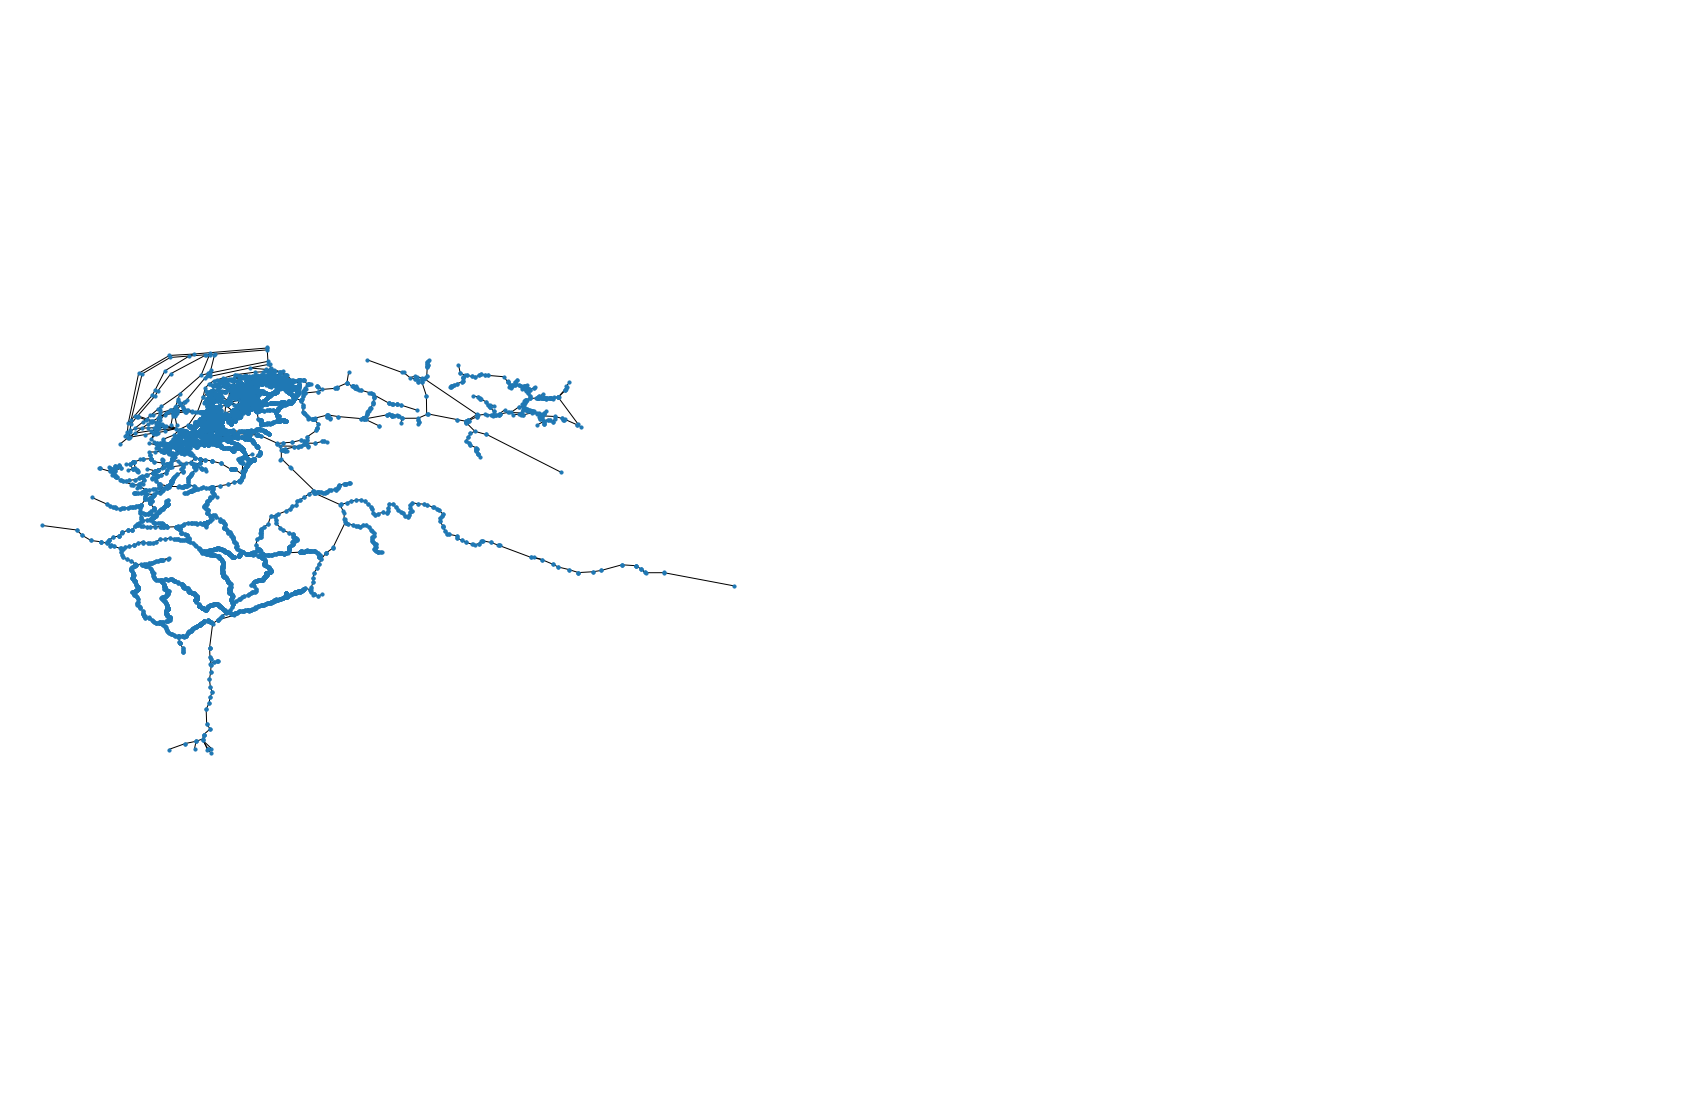

In [46]:
# this is the subway version of the corridor
fig, axes = plt.subplots(ncols=2, figsize=(30, 20))

spatial_pos = {
    k: (v['X'], v['Y']) 
    for k, v 
    in network.nodes.items()
}
nx.draw(
    network, 
    pos=spatial_pos, 
    node_size=10,
    ax=axes[0]
)
axes[0].axis('equal')

# Visualize in a different layout to inspect for artefacts (should look like a ball of wool with some tentacles)
pos = nx.spring_layout(network, pos=spatial_pos, weight='Length', iterations=10)

nx.draw(
    network, 
    pos=pos, 
    node_size=10,
    ax=axes[1]
)
axes[1].axis('equal')
plt.show()